No subsidy:  31.673867297103605
25.3102303525247
43.76800947431379
Current subsidy:  22.011981259206177
17.59989298279881
30.395270517934623
50% subsidy:  15.836933648551803
12.65511517626235
21.884004737156896


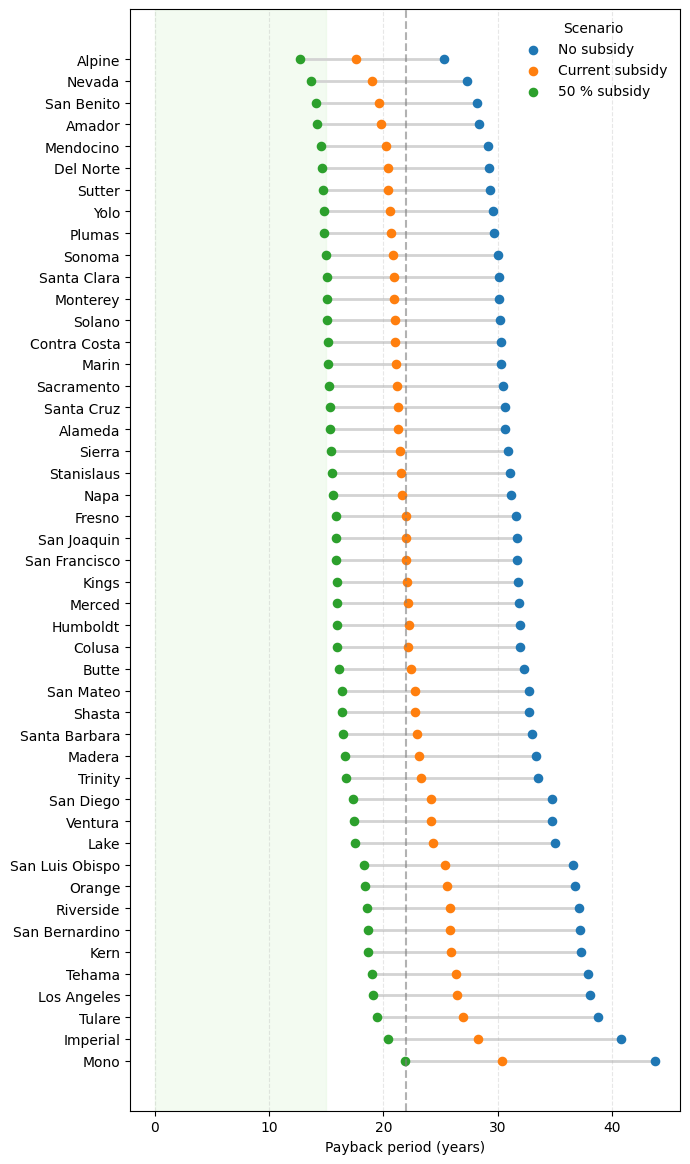

In [37]:
# payback_dumbbell_fixed.py
# -------------------------------------------------------------
# Compare payback periods for 3 incentive scenarios.
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pathlib import Path

BASE_DIR = Path(
    "../data/loadprofiles/heat_pump_and_induction_stove_and_water_heating/single-family-detached/RESULTS/geojson"
)

FILES = {
    "No subsidy"     : "none_heat_pump_and_induction_stove_and_water_heating.geojson",
    "Current subsidy" : "normal_heat_pump_and_induction_stove_and_water_heating.geojson",
    "50 % subsidy"   : "half_heat_pump_and_induction_stove_and_water_heating.geojson",
}

METRIC_COL = "Payback Period (Electrification + Solar + Storage)"  # column to compare

# ---------- 2) load, align, de-duplicate ----------
dfs = []
for label, fname in FILES.items():
    gdf = (
        gpd.read_file(BASE_DIR / fname)[["NAME", METRIC_COL]]
        .rename(columns={METRIC_COL: label})
    )
    dfs.append(gdf)

# merge on county name (inner join keeps only counties present in all 3)
df = dfs[0]
for extra in dfs[1:]:
    df = df.merge(extra, on="NAME", how="inner")

# some TIGER/GeoJSON files contain multiple geometries for the same county
# → collapse duplicates by *taking the first* (or use .mean() / .median()).
df = (
    df.groupby("NAME", as_index=False)
      .first()                    # keep the first geometry's values
      .dropna()                   # drop counties that still have missing numbers
      .sort_values("No subsidy")  # order rows (baseline column)
      .reset_index(drop=True)
)

# --------- 2.5) metrics ----------
print("No subsidy: ", df["No subsidy"].median())
print(df["No subsidy"].min())
print(df["No subsidy"].max())
print("Current subsidy: ", df["Current subsidy"].median())
print(df["Current subsidy"].min())
print(df["Current subsidy"].max())
print("50% subsidy: ", df["50 % subsidy"].median())
print(df["50 % subsidy"].min())
print(df["50 % subsidy"].max())

# ---------- 3) plotting ----------
scenarios = list(FILES.keys())
colour_map = {
    "No subsidy"    : "#1f77b4",  # blue
    "Current subsidy": "#ff7f0e",  # orange
    "50 % subsidy"  : "#2ca02c",  # green
}

fig_h = max(5, 0.25 * len(df))       # stretch vertically if many counties
fig, ax = plt.subplots(figsize=(7, fig_h))

# (a) horizontal “stem” lines for each county
for y, (_, row) in enumerate(df.iterrows()):
    ax.hlines(
        y,
        xmin=row[scenarios].min(),
        xmax=row[scenarios].max(),
        color="lightgray",
        linewidth=2,
        zorder=1,
    )

# (b) scatter dots – *one call per scenario* so colour is consistent
for scen in scenarios:
    ax.scatter(
        df[scen],
        df.index,
        label=scen,
        color=colour_map[scen],
        s=35,
        zorder=2,
    )

# ---------- 4) cosmetics ----------
ax.set_xlabel("Payback period (years)")
ax.set_yticks(df.index)
ax.set_yticklabels(df["NAME"])
ax.invert_yaxis()                       # top-to-bottom alphabet feels natural
ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.legend(title="Scenario", frameon=False, loc="upper right")
ax.axvspan(0, 15, color='#d8f5d3', alpha=0.3, zorder=0)
ax.axvline(df['Current subsidy'].median(), ls='--', color='grey', alpha=0.6)

plt.tight_layout()
plt.show()

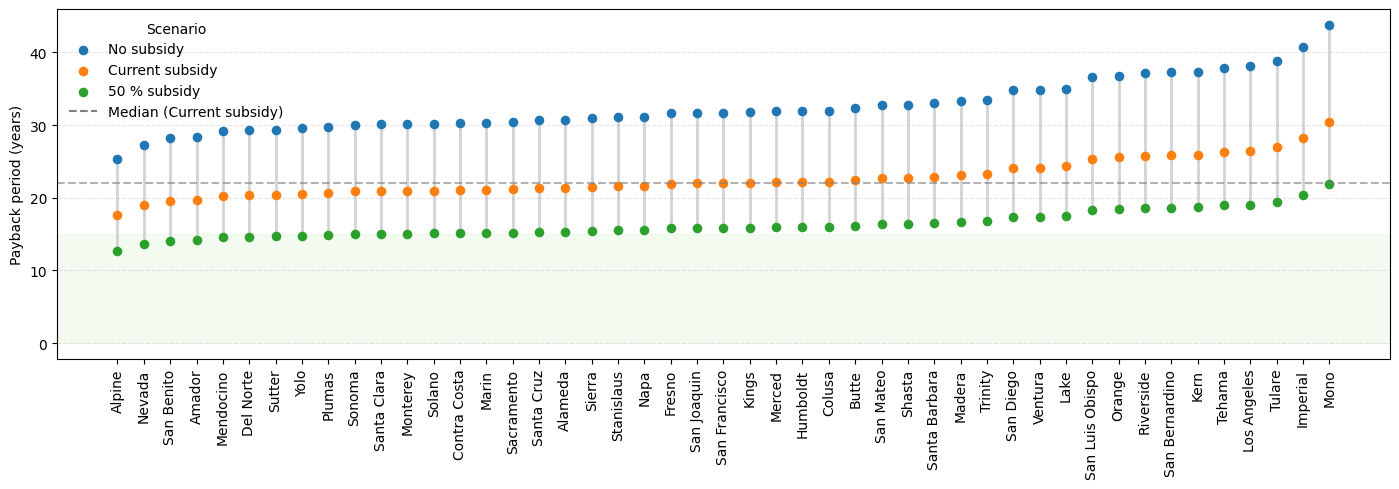

In [38]:
fig_w = max(7, 0.3 * len(df))  # stretch horizontally if many counties
fig, ax = plt.subplots(figsize=(fig_w, 5))

# (a) vertical “stem” lines for each county
for x, (_, row) in enumerate(df.iterrows()):
    ax.vlines(
        x,
        ymin=row[scenarios].min(),
        ymax=row[scenarios].max(),
        color="lightgray",
        linewidth=2,
        zorder=1,
    )

# (b) scatter dots – one call per scenario so color stays consistent
for scen in scenarios:
    ax.scatter(
        df.index,
        df[scen],
        label=scen,
        color=colour_map[scen],
        s=35,
        zorder=2,
    )

# ---------- 4) cosmetics ----------
ax.set_ylabel("Payback period (years)")
ax.set_xticks(df.index)
ax.set_xticklabels(df["NAME"], rotation=90)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.axhspan(0, 15, color='#d8f5d3', alpha=0.3, zorder=0)
ax.axhline(df['Current subsidy'].median(), ls='--', color='grey', alpha=0.6)
ax.legend(title="Scenario", frameon=False, loc="upper left")

import matplotlib.lines as mlines
median_line = mlines.Line2D([], [], color='grey', linestyle='--', label='Median (Current subsidy)')
ax.legend(handles=[*ax.get_legend_handles_labels()[0], median_line], title="Scenario", frameon=False, loc="upper left")

plt.tight_layout()
plt.show()

41 of 47 counties (87.2 %) pay back within 15 years.
Median: 12.994087618645358 Min: 11.066287353050429 Max: 17.119273561608093


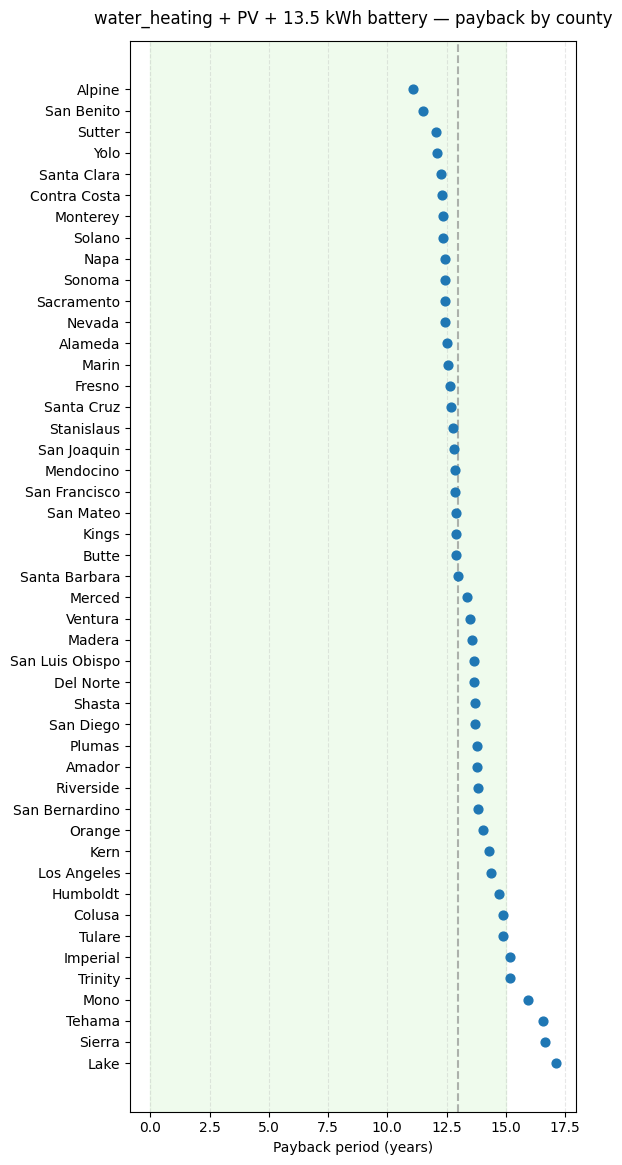

In [39]:
# payback_dotplot_induction.py
# ------------------------------------------------------------------
# One–scenario dot plot: payback of “induction-stove + PV + battery”
# under the current incentive structure.
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pathlib import Path

scenario = "water_heating"

# ‣ 1.  File locations ------------------------------------------------
BASE_DIR  = Path(
    f"../data/loadprofiles/{scenario}/single-family-detached/RESULTS/geojson"
)
GEOJSON   = f"{scenario}.geojson"        # ← adjust if name differs
METRIC_COL = "Payback Period (Electrification + Solar + Storage)"

# ‣ 2.  Load, clean ---------------------------------------------------
df = (
    gpd.read_file(BASE_DIR / GEOJSON)[["NAME", METRIC_COL]]
      .rename(columns={METRIC_COL: "Payback"})
      .groupby("NAME", as_index=False)   # handle multi-polygon counties
      .first()                           # keep first record
      .dropna(subset=["Payback"])        # drop missing
      .sort_values("Payback")            # low → high
      .reset_index(drop=True)
)

# --- quick summary of ≤15-year results --------------------------
within_15 = (df["Payback"] <= 15).sum()
total     = len(df)
share     = within_15 / total * 100          # percent of counties

print(f"{within_15} of {total} counties ({share:.1f} %) pay back within 15 years.")

# quick stats for the console
print("Median:", df["Payback"].median(),
      "Min:", df["Payback"].min(),
      "Max:", df["Payback"].max())

# ‣ 3.  Plot ----------------------------------------------------------
fig_h = max(5, 0.25 * len(df))              # auto height
fig, ax = plt.subplots(figsize=(6, fig_h))

# shaded “within-lifetime” band (≤ 15 yr)
ax.axvspan(0, 15, color="#d8f5d3", alpha=0.4, zorder=0)

# dotted median line
ax.axvline(df["Payback"].median(), ls="--", color="grey", alpha=0.6)

# scatter points
ax.scatter(df["Payback"], df.index,
           color="#1f77b4", s=40, zorder=2)

# axis & labels
ax.set_xlabel("Payback period (years)")
ax.set_yticks(df.index)
ax.set_yticklabels(df["NAME"])
ax.invert_yaxis()                 # top county = smallest payback
ax.grid(axis="x", ls="--", alpha=0.3)

ax.set_title(
    f"{scenario} + PV + 13.5 kWh battery — payback by county",
    pad=12,                 # space above the axes (pt)
    fontsize=12
)


plt.tight_layout()
plt.show()